In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns

sns.set_theme(style="darkgrid")

In [70]:
os.listdir("profile-dir/")

['_cuda_kern_exec_trace_nvtx=prefill_4096-sm_32-iter_0.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_96-iter_0.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_96-iter_1.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_64-iter_1.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_64-iter_0.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_32-iter_1.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_128-iter_0.csv',
 '_cuda_kern_exec_trace_nvtx=prefill_4096-sm_128-iter_1.csv']

In [74]:
trace_per_sm = {}
for file in os.listdir("profile-dir/"):
    # only capture iter_1 data
    if "iter_1" not in file:
        continue
    sm = int(file.split("-")[1].split("_")[1])
    df_ = pd.read_csv(f"profile-dir/{file}")

    df_["num_blocks"] = df_["GridXYZ"].map(lambda x: math.prod(
        map(int, (filter(lambda y: y != "",
                         x.strip().split(" "))))))
    trace_per_sm[sm] = df_


Total kernel time for SM 96: 92.147706 ms
Total kernel time for SM 64: 129.840146 ms
Total kernel time for SM 32: 223.128501 ms
Total kernel time for SM 128: 82.255646 ms


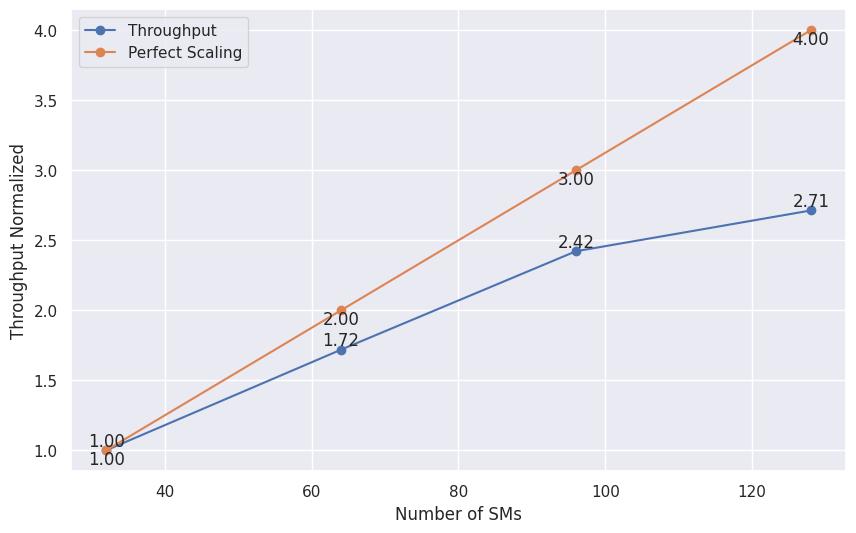

In [75]:
data = []

for sm, trace in trace_per_sm.items():
    total_time_ms = trace['Kernel Dur (ns)'].sum() / 1e6
    print(f"Total kernel time for SM {sm}: {total_time_ms} ms")

    data.append({"sm": sm, "total_time_ms": total_time_ms})

df = pd.DataFrame(data)
df = df.sort_values(by="sm")
df["throughput_ops_per_ms"] = 1 / df["total_time_ms"]
df["perfect_scaling_throughput_ops_per_ms"] = df.iloc[0][
    "throughput_ops_per_ms"] * (df["sm"] / 32)

df["throughput_normalized"] = df["throughput_ops_per_ms"] / df.iloc[0][
    "throughput_ops_per_ms"]
df["perfect_scaling_throughput_normalized"] = df[
    "perfect_scaling_throughput_ops_per_ms"] / df.iloc[0][
        "throughput_ops_per_ms"]

plt.figure(figsize=(10, 6))
plt.plot(df["sm"], df["throughput_normalized"], 'o-', label="Throughput")
plt.plot(df["sm"],
         df["perfect_scaling_throughput_normalized"],
         'o-',
         label="Perfect Scaling")
for x, y in zip(df["sm"], df["throughput_normalized"]):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df["sm"], df["perfect_scaling_throughput_normalized"]):
    plt.text(x, y, f'{y:.2f}', ha='center', va='top')
plt.xlabel('Number of SMs')
plt.ylabel('Throughput Normalized')
plt.legend()
plt.show()


In [ ]:
kernel_id_map = {k: i for i, k in enumerate(df["Kernel Name"].unique())}
df["kernel_id"] = df["Kernel Name"].map(kernel_id_map)

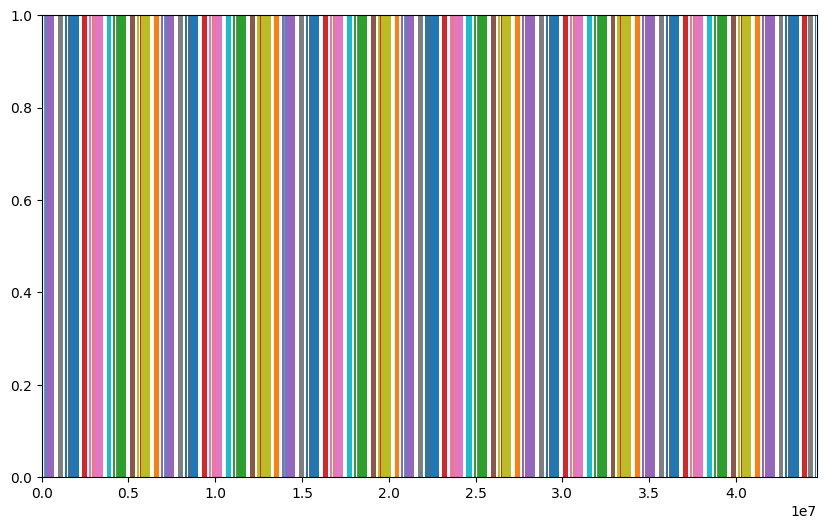

In [38]:
# make a timeline bar plot of kernel dur ns as x, and num_blocks as y, color by kernel name

total_duration = df['Kernel Dur (ns)'].sum()
max_y = df['num_blocks'].max()

plt.figure(figsize=(10, 6))
plt.xlim(0, total_duration)
plt.ylim(0, 1)

x = 0
for _, row in df.iterrows():
    plt.bar(x, 1, width=row['Kernel Dur (ns)'], label=row['kernel_id'])
    x += row['Kernel Dur (ns)']

plt.show()

In [42]:
print(f"Total duration: {df['Kernel Dur (ns)'].sum() / 1e6} ms")

Total duration: 44.656264 ms


In [4]:
import math

# this has a bug, the prefill time is for batch of 64 prefill together.
decode_32 = 17.883616
decode_64 = 5.952024
decode_96 = 4.761024
decode_128 = 4.259052
prefill_32 = 235.493499
prefill_64 = 135.516896
prefill_96 = 96.027568
prefill_128 = 84.845828

data = {
    ("prefill", 32): prefill_32,
    ("prefill", 64): prefill_64,
    ("prefill", 96): prefill_96,
    ("prefill", 128): prefill_128,
    ("decode", 32): decode_32,
    ("decode", 64): decode_64,
    ("decode", 96): decode_96,
    ("decode", 128): decode_128,
}

# mps 100 scenario
scenarios = [
    (1, 1),
    (1, 5),
    (1, 10),
    (1, 20),
    (1, 40),
    (2, 1),
]

result = []

for prefill, decode in scenarios:
    for prefill_split, decode_split in [(32, 96), (64, 64), (96, 32)]:
        prefill_time = data[("prefill", prefill_split)] * prefill
        decode_time = data[("decode", decode_split)] * decode

        # e2e_time = max(prefill_time, decode_time)

        # approach 2: run concurent first, then run remaining fraction in 128 SMs
        # concurrent_time = min(prefill_time, decode_time)
        # remaining_time = max(prefill_time, decode_time) - concurrent_time
        # remaining_side = "prefill" if prefill_time > decode_time else "decode"
        # if remaining_side == "prefill":
        #     computed_fraction = concurrent_time / prefill_time
        #     remaining_time = data[("prefill", 128)] * prefill * (1 - computed_fraction)
        # else:
        #     computed_fraction = concurrent_time / decode_time
        #     remaining_time = data[("decode", 128)] * decode * (1 - computed_fraction)
        # e2e_time = concurrent_time + remaining_time

        # approach 3: only run in 128 SMs for the extra dispatch
        concurrent_time = min(prefill_time, decode_time)
        remaining_time = max(prefill_time, decode_time) - concurrent_time
        remaining_side = "prefill" if prefill_time > decode_time else "decode"
        concurrent_time_per_kernel = data[(remaining_side, prefill_split)]
        remaining_num_kernels = remaining_time / concurrent_time_per_kernel
        if remaining_num_kernels >= 1:
            left_running_concurrent = remaining_num_kernels % 1.0
            left_running_concurrent_time = left_running_concurrent * concurrent_time_per_kernel

            left_running_standlone = math.floor(remaining_num_kernels)
            left_running_standlone_time = left_running_standlone * data[
                (remaining_side, 128)]

            remaining_time = left_running_concurrent_time + left_running_standlone_time
        e2e_time = concurrent_time + remaining_time

        result.append({
            "workload": f"{prefill}-{decode}",
            "strategy": f"{prefill_split}-{decode_split}",
            "e2e_time": e2e_time,
        })

    mps_time = prefill_128 * prefill + decode_128 * decode
    result.append({
        "workload": f"{prefill}-{decode}",
        "strategy": "mps-100",
        "e2e_time": mps_time,
    })

df = pd.DataFrame(result)
df = df.pivot(index="workload", columns="strategy", values="e2e_time")

# bold the min value in each row
for index, row in df.iterrows():
    min_value = row.min()
    for column in row.index:
        if row[column] == min_value:
            df.loc[index, column] = f"**{min_value}**"

df

/data/tmp/ipykernel_3131738/2227687122.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**89.10488**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, column] = f"**{min_value}**"
/data/tmp/ipykernel_3131738/2227687122.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**135.516896**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, column] = f"**{min_value}**"
/data/tmp/ipykernel_3131738/2227687122.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**96.027568**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, column] = f"**{min_value}**"


strategy,32-96,64-64,96-32,mps-100
workload,,,,
1-1,235.493499,135.516896,96.027568,**89.10488**
1-10,235.493499,135.516896,170.302636,**127.436348**
1-20,235.493499,**135.516896**,330.565832,170.026868
1-40,235.493499,**209.300436**,650.08828,255.207908
1-5,235.493499,135.516896,**96.027568**,106.141088
2-1,320.339327,220.362724,180.873396,**173.950708**
